<a href="https://colab.research.google.com/github/YonDraco/learn-pyimagesearch/blob/master/5_minivggnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

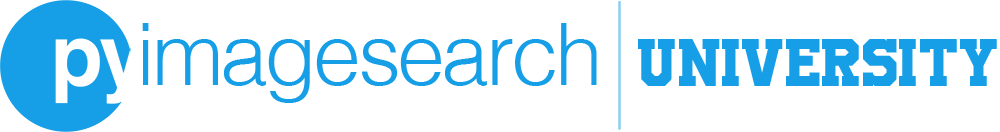

# MiniVGGNet: Going Deeper with CNNs
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch University](https://pyimg.co/university)** Jupyter Notebooks!

This notebook is associated with the [MiniVGGNet: Going Deeper with CNNs](https://www.pyimagesearch.com/2021/05/22/minivggnet-going-deeper-with-cnns/) blog post published on 2021-05-22.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch University Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2021 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch University at https://pyimg.co/university today.*

### Download the code zip file

In [1]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/minivggnet/minivggnet.zip
!unzip -qq minivggnet.zip
%cd minivggnet

--2021-08-25 17:20:48--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/minivggnet/minivggnet.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.218.213.65
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.218.213.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10844 (11K) [binary/octet-stream]
Saving to: ‘minivggnet.zip’

minivggnet.zip      100%[===================>]  10.59K  --.-KB/s    in 0s      

2021-08-25 17:20:48 (95.6 MB/s) - ‘minivggnet.zip’ saved [10844/10844]

/content/minivggnet


## Blog Post Code

### Import Packages

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

### Implementing MiniVGGNet

In [3]:
class MiniVGGNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# first CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# second CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

### MiniVGGNet on CIFAR-10

In [4]:
# load the training and testing data, then scale it into the
# range [0, 1]
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# initialize the label names for the CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer",
	"dog", "frog", "horse", "ship", "truck"]

[INFO] loading CIFAR-10 data...
170508288/170498071 [==============================] - 4s 0us/step


In [5]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=0.01, decay=0.01 / 40, momentum=0.9, nesterov=True)
model = MiniVGGNet.build(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY),
	batch_size=64, epochs=40, verbose=1)

[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


[INFO] training network...
Epoch 1/40
782/782 [==============================] - 24s 9ms/step - loss: 1.6104 - accuracy: 0.4616 - val_loss: 1.2922 - val_accuracy: 0.5547
Epoch 2/40
782/782 [==============================] - 7s 9ms/step - loss: 1.1470 - accuracy: 0.5993 - val_loss: 0.9638 - val_accuracy: 0.6602
Epoch 3/40
782/782 [==============================] - 7s 9ms/step - loss: 0.9681 - accuracy: 0.6622 - val_loss: 0.8869 - val_accuracy: 0.6872
Epoch 4/40
782/782 [==============================] - 7s 9ms/step - loss: 0.8601 - accuracy: 0.6970 - val_loss: 0.7848 - val_accuracy: 0.7243
Epoch 5/40
782/782 [==============================] - 7s 9ms/step - loss: 0.7863 - accuracy: 0.7225 - val_loss: 0.7099 - val_accuracy: 0.7500
Epoch 6/40
782/782 [==============================] - 7s 9ms/step - loss: 0.7259 - accuracy: 0.7450 - val_loss: 0.7142 - val_accuracy: 0.7491
Epoch 7/40
782/782 [==============================] - 7s 9ms/step - loss: 0.6780 - accuracy: 0.7609 - val_loss: 0.6799 -

In [6]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
              precision    recall  f1-score   support

    airplane       0.84      0.84      0.84      1000
  automobile       0.92      0.93      0.93      1000
        bird       0.80      0.70      0.75      1000
         cat       0.67      0.68      0.68      1000
        deer       0.77      0.82      0.80      1000
         dog       0.77      0.72      0.75      1000
        frog       0.82      0.90      0.86      1000
       horse       0.87      0.87      0.87      1000
        ship       0.90      0.91      0.91      1000
       truck       0.90      0.89      0.90      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



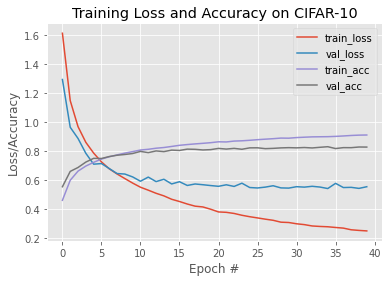

In [7]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 40), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 40), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 40), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on CIFAR-10")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*MiniVGGNet: Going Deeper with CNNs*](https://www.pyimagesearch.com/2021/05/22/minivggnet-going-deeper-with-cnns/) published on 2021-05-22.

# Code License Agreement
```
Copyright (c) 2021 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```